# Smart Building Climate Control

A case study in building a model to predict room occupancy from environmental sensors. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from scipy.stats import zscore

from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sns

### 1) Data Exploration


In [2]:
data_train = pd.read_table('data/datatraining.txt', delimiter=",")
data_test1 = pd.read_table('data/datatest.txt', delimiter=",")
data_test2 = pd.read_table('data/datatest2.txt', delimiter=",")

Two test datasets were provided. 

In [3]:
def explore_df(df):
    print(f"Number of samples: {len(df)}")
    print(f"Number of null lines:\n{df.isnull().sum()}")
    print(f"Attributes: {list(df.columns)}")
    print(df.info())
    # print(df.describe())
    return 


explore_df(data_train)
# explore_df(data_test1)
# explore_df(data_test2)

Number of samples: 8143
Number of null lines:
date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64
Attributes: ['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']
<class 'pandas.core.frame.DataFrame'>
Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB
None


### 2) Visualization

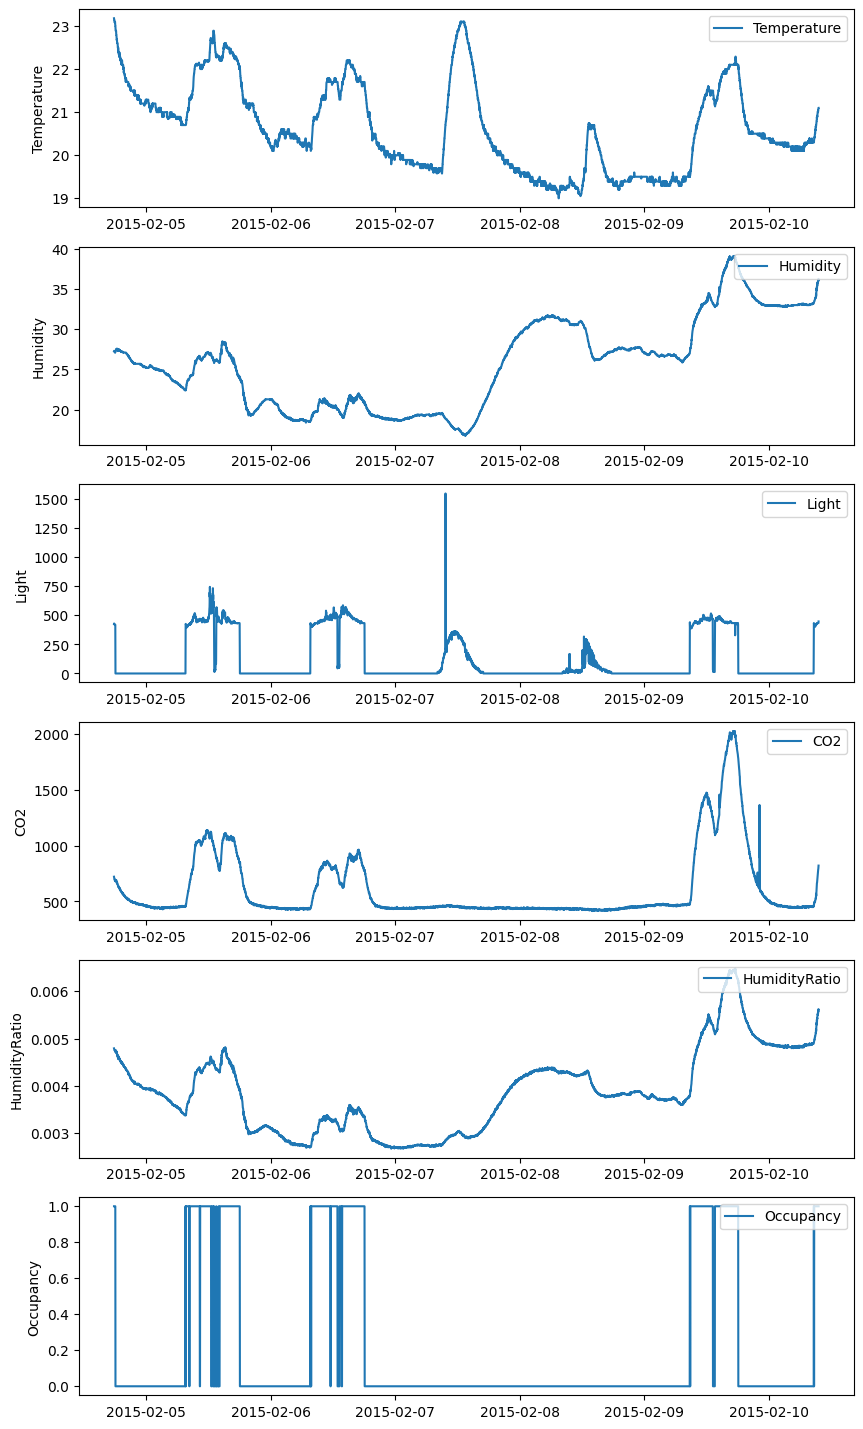

In [4]:
def plot_summary(df):
    x = df['date'].tolist()
    xtime = pd.to_datetime(x)

    attributes = [name for name in df.columns if name != 'date']
    fig, axes = plt.subplots(len(attributes), 1, figsize=(10, 3 * len(attributes)), sharex=False)
    for ax, name in zip(axes, attributes):
        ax.plot(xtime, df[name], '-', label=name)
        ax.set_ylabel(name)
        ax.legend(loc='upper right')

plot_summary(data_train)
# plot_summary(data_test1)
# plot_summary(data_test2)

To summarize some observations:
* Each dataset has 6-7 days of ~2000-9000 timestamps
* The density of the timestamps varies between the provided test datasets
* The train dataset has some outliers in the Light attribute
* The datasets contain both weekdays and weekends which should be noted

To remove outliers in case they affect results, use a z score and remove any value that is >3 standard deviations away from the mean. 

In [5]:
def remove_outliers(df, feature):
    z_scores = np.abs(zscore(df[feature]))
    df_cleaned = df[z_scores < 3]
    return df_cleaned

data_train = remove_outliers(data_train, 'Light')
data_test1 = remove_outliers(data_test1, 'Light')
data_test2 = remove_outliers(data_test2, 'Light')
data_test = pd.concat([data_test1, data_test2])

### 3) Determine feature importance

By visual inspection, CO2 has the best correlation with room human occupancy. However, mutual information scoring determines that the light attribute has the highest correlation. Given the high score, suggest to model room occupancy on this feature. 

In [6]:
# calculate correlation between each attribute and occupany
def show_mutual_info(df, target):
    X = df.drop(columns=['date', target])
    y = df[target]
    mutual_info = mutual_info_classif(X, y, n_neighbors=5)
    names = list(X.columns)
    print(names)
    print(mutual_info)
    return names, mutual_info

names, mutual_info = show_mutual_info(data_train, 'Occupancy')

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
[0.22634587 0.19270625 0.47498079 0.34444658 0.23405088]


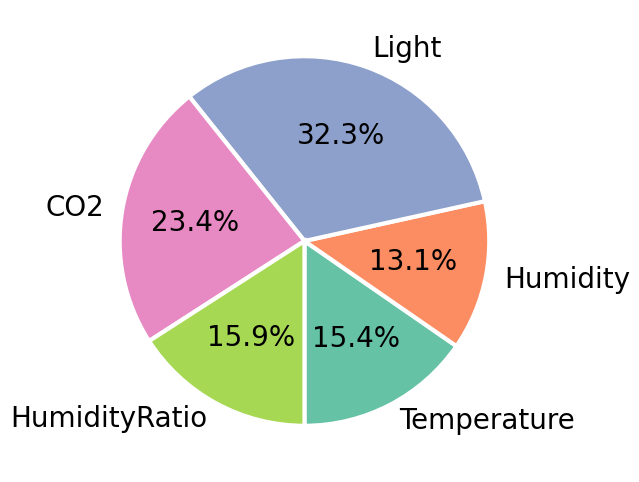

In [7]:
# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    mutual_info,
    labels=names,
    autopct='%1.1f%%', 
    startangle=270, 
    colors=plt.cm.Set2.colors,  
    wedgeprops={'edgecolor': 'white', 'linewidth': 3} ,
    textprops={'size': 20, 'color': 'black'}
)
plt.savefig("p1_pie.png", bbox_inches="tight", transparent=True)

### 4) Build and evaluate model

Use a simple logistic regression model for binary classification

In [8]:
# prepare input data for training and testing
feature = 'Light'
X_train = data_train[feature].values.reshape(-1, 1)
y_train = data_train['Occupancy']
X_test = data_test[feature].values.reshape(-1, 1)
y_test = data_test['Occupancy']

# define model, use default parameters
model = LogisticRegression()
model.fit(X_train, y_train)
print(model)

LogisticRegression()


In [9]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", model.score(X_test, y_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return 

evaluate_metrics(model, X_train, y_train, X_test, y_test)

Training Accuracy: 0.9879562492319036
Testing Accuracy: 0.9898000815993472
Confusion Matrix:
 [[9286  110]
 [  15 2844]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9396
           1       0.96      0.99      0.98      2859

    accuracy                           0.99     12255
   macro avg       0.98      0.99      0.99     12255
weighted avg       0.99      0.99      0.99     12255



#### Visualize evaluation

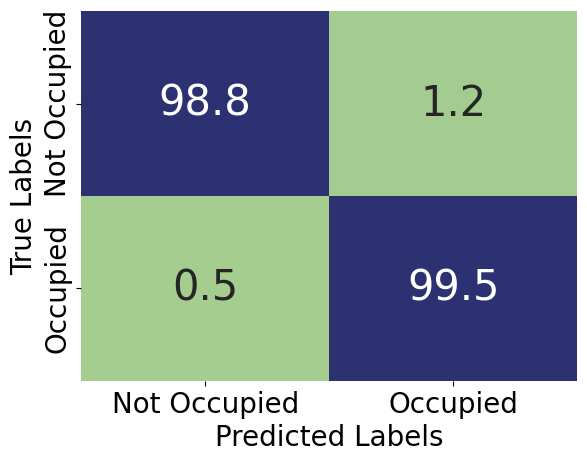

In [10]:
labels = ['Not Occupied', 'Occupied']
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fsz_fig = 30
fsz_ax = 20
sns.heatmap(
    cm_percentage, annot=True, fmt='.1f', cmap='crest', 
    xticklabels=labels, yticklabels=labels, cbar=False,
    linecolor='black', linewidths=0,
    annot_kws={"size": fsz_fig}
)
plt.xlabel('Predicted Labels', fontsize=fsz_ax)
plt.ylabel('True Labels', fontsize=fsz_ax)
plt.xticks(fontsize=fsz_ax)
plt.yticks(fontsize=fsz_ax)
plt.savefig("p1_heatmap.png", bbox_inches="tight", transparent=True)